In [2]:
import pandas as pd
import numpy as np
# load csv files:
dataset_train = pd.read_csv('/DL_course_data/Lab5/train_data_stock.csv') 
dataset_val = pd.read_csv('/DL_course_data/Lab5/val_data_stock.csv')

# reverse data so that they go from oldest to newest:
dataset_train = dataset_train.iloc[::-1]
dataset_val = dataset_val.iloc[::-1]

# concatenate training and test datasets:
dataset_total = pd.concat((dataset_train['Open'], dataset_val['Open']), axis=0)

# select the values from the “Open” column as the variables to be predicted: 
training_set = dataset_train.iloc[:, 1:2].values
val_set = dataset_val.iloc[:, 1:2].values

In [10]:
dataset_val

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
15,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749,3486.05
14,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590,3960.27
13,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786,3815.79
12,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515,7407.06
11,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146,10062.83
10,2018-10-09,215.50,219.15,209.60,215.00,216.50,1844462,3940.70
9,2018-10-10,215.00,229.65,215.00,228.25,228.40,2919278,6557.95
8,2018-10-11,215.00,229.70,215.00,225.60,224.60,1293881,2890.85
7,2018-10-12,226.25,232.35,225.50,228.70,229.10,1165527,2675.91
6,2018-10-15,229.70,237.00,226.80,234.80,234.90,1224339,2845.68


In [3]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1)) 
training_set_scaled = sc.fit_transform(training_set)

In [19]:
len(val_set)

16

In [15]:
# split training data into T time steps:
X_train = []
y_train = []
T = 60

for i in range(T, len(training_set)):
    X_train.append(training_set_scaled[i-T:i, 0])  # choose period of T
    y_train.append(training_set_scaled[i, 0]) # value at the end of period

X_train, y_train = np.array(X_train), np.array(y_train)

# normalize the validation set according to the normalization applied to the training set:
inputs = dataset_total[len(dataset_total) - len(dataset_val) - 60:].values 
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

<ipython-input-15-8201a56ab520>:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  inputs = dataset_total[len(dataset_total) - len(dataset_val) - 60:].values


In [17]:
val_set

array([[234.55],
       [230.  ],
       [223.5 ],
       [217.  ],
       [208.  ],
       [215.5 ],
       [215.  ],
       [215.  ],
       [226.25],
       [229.7 ],
       [237.1 ],
       [237.7 ],
       [230.3 ],
       [229.45],
       [221.1 ],
       [220.1 ]])

In [24]:
# split validation data into T time steps:
X_val = []
for i in range(T, T + len(val_set)): 
    X_val.append(inputs[i-T:i, 0])
X_val = np.array(X_val)
y_val = sc.transform(val_set)

# reshape to 3D array (format needed by LSTMs -> number of samples, timesteps, input dimension)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [26]:
X_train.shape

(1920, 60, 1)

In [6]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, SimpleRNN, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [58]:
len(X_train) // 16

120

In [113]:
def model(step, units):
    model = Sequential()

    # Add four LSTM layers
    model.add(LSTM(units=units, batch_input_shape=(16, step, 1), return_sequences= True, stateful = True ))
    model.add(Dropout(0.2))

    model.add(LSTM(units=units, return_sequences= True, stateful = True ))
    model.add(Dropout(0.2))

    model.add(LSTM(units=units, return_sequences= True, stateful = True ))
    model.add(Dropout(0.2))

    model.add(LSTM(units=units, return_sequences= False, stateful = True ))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation="linear"))
    model.summary()

    return model

In [34]:
X_train.shape

(1920, 60, 1)

In [97]:
def plot(History):
    plt.figure(figsize=(4, 4))
    plt.title("Learning curve")
    plt.plot(History.history["loss"], label="loss")
    plt.plot(History.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(History.history["val_loss"]),
            np.min(History.history["val_loss"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.show()

    plt.figure

    plt.figure(figsize=(4, 4))
    plt.title("mean_absolute_error")
    plt.plot(History.history["mean_absolute_error"], label="mean_absolute_error")
    plt.plot(History.history["val_mean_absolute_error"], label="val_mean_absolute_error")
    plt.plot( np.argmin(History.history["val_mean_absolute_error"]),
            np.min(History.history["val_mean_absolute_error"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("mean_absolute_error")
    plt.legend()
    plt.show()

In [106]:
LR = 0.001
epochs = 100

model = model(T,20)
model.compile(loss='mean_squared_error', optimizer = Adam(lr = LR), metrics=['mean_absolute_error'])
model_history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size= 16,
        epochs = epochs,  verbose=1)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_91 (LSTM)              (16, 60, 20)              1760      
                                                                 
 dropout_87 (Dropout)        (16, 60, 20)              0         
                                                                 
 lstm_92 (LSTM)              (16, 60, 20)              3280      
                                                                 
 dropout_88 (Dropout)        (16, 60, 20)              0         
                                                                 
 lstm_93 (LSTM)              (16, 60, 20)              3280      
                                                                 
 dropout_89 (Dropout)        (16, 60, 20)              0         
                                                                 
 lstm_94 (LSTM)              (16, 20)                

In [111]:
np.min(model_history.history["val_mean_absolute_error"])
np.min(model_history.history["val_loss"])


0.0007514958851970732

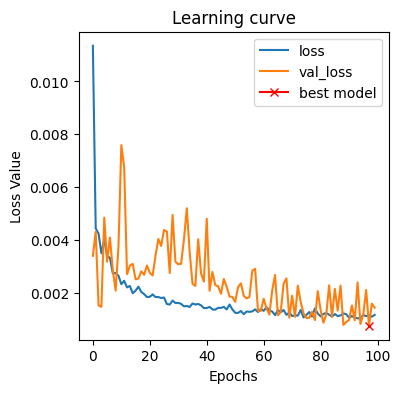

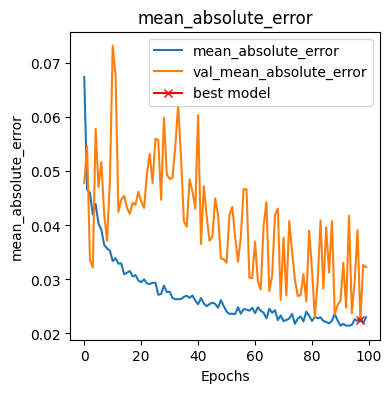

In [107]:
plot(model_history)

In [114]:
LR = 0.001
epochs = 100

model = model(T,40)
model.compile(loss='mean_squared_error', optimizer = Adam(lr = LR), metrics=['mean_absolute_error'])
model_history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size= 16,
        epochs = epochs,  verbose=1)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_95 (LSTM)              (16, 60, 40)              6720      
                                                                 
 dropout_91 (Dropout)        (16, 60, 40)              0         
                                                                 
 lstm_96 (LSTM)              (16, 60, 40)              12960     
                                                                 
 dropout_92 (Dropout)        (16, 60, 40)              0         
                                                                 
 lstm_97 (LSTM)              (16, 60, 40)              12960     
                                                                 
 dropout_93 (Dropout)        (16, 60, 40)              0         
                                                                 
 lstm_98 (LSTM)              (16, 40)                

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


120/120 [==============================] - 5s 17ms/step - loss: 0.0108 - mean_absolute_error: 0.0662 - val_loss: 0.0025 - val_mean_absolute_error: 0.0394
Epoch 2/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0034 - mean_absolute_error: 0.0425 - val_loss: 0.0035 - val_mean_absolute_error: 0.0491
Epoch 3/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0429 - val_loss: 0.0017 - val_mean_absolute_error: 0.0341
Epoch 4/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0375 - val_loss: 0.0024 - val_mean_absolute_error: 0.0390
Epoch 5/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0029 - mean_absolute_error: 0.0375 - val_loss: 0.0024 - val_mean_absolute_error: 0.0393
Epoch 6/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0367 - val_loss: 0.0030 - val_mean_absolute_error: 0.0433
Epoch 7/100
120/120 [

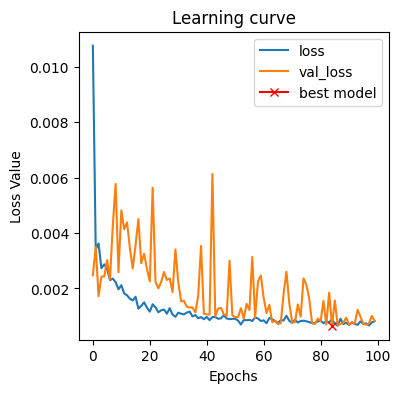

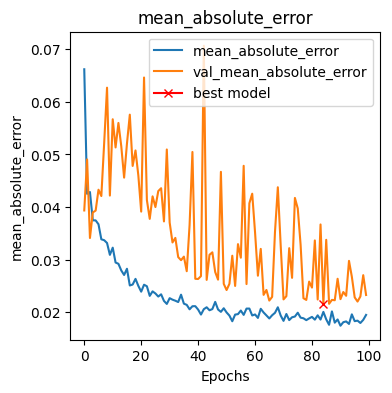

In [115]:
plot(model_history)

In [116]:
print(np.min(model_history.history["val_mean_absolute_error"]))
print(np.min(model_history.history["val_loss"]))


0.021572545170783997
0.0006556352600455284


In [121]:
predicted_stock_price = model.predict(X_val)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

1/1 [==============================] - 0s 20ms/step


array([[230.31535],
       [230.36958],
       [227.09624],
       [221.53435],
       [215.38582],
       [207.24501],
       [210.59364],
       [211.10985],
       [211.03778],
       [219.31337],
       [223.99934],
       [230.52138],
       [232.5773 ],
       [227.80536],
       [226.17079],
       [219.81741]], dtype=float32)